In [1]:
import torch

# ============================================================
# Dataset Building for Character-Level Language Model
# ============================================================
with open('names.txt', 'r') as f:
    words = f.read().splitlines()

In [2]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [3]:
import torch
import numpy as np
from torch import Tensor

# Fix random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Sample word list (if not already defined)
# words = ["some", "example", "words", "here"]

# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182778, 8]) torch.Size([182778])
torch.Size([22633, 8]) torch.Size([22633])
torch.Size([22735, 8]) torch.Size([22735])


In [4]:


class LinearLayer:
    def __init__(self, f_in, f_out, bias=True) -> None:
        self.f_in = f_in
        self.f_out = f_out
        self.bias = bias


        self.w = torch.randn((self.f_in, self.f_out), requires_grad=True)
        if self.bias:
            self.b = torch.zeros(self.f_out, requires_grad=True)
        else:
            self.b = None

    def __call__(self, x):
        if self.bias:
            return x @ self.w + self.b
        else:
            return x @ self.w

    def parameters(self):
        return [self.w] if self.b is None else [self.w, self.b]



class EmbeddingLayer:
    def __init__(self, n_emb, d_emb) -> None:

        self.emb = torch.randn((n_emb, d_emb), requires_grad=True)

    def __call__(self, x):

        x = x.long()
        return self.emb[x]

    def parameters(self):
        return [self.emb]
    

class FlattenConsecutive:
    def __init__(self,n) -> None:
        self.n = n

    
    def __call__(self,x):
        i, j, k = x.shape
        x = x.view(i, j//self.n, k*self.n)
        if x.shape[1] == 1:
          x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
      return []
    
class Tanh:
  def __call__(self, x):
    return torch.tanh(x)
  def parameters(self):
    return []


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]
    

In [5]:

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  EmbeddingLayer(vocab_size, n_embd),
  FlattenConsecutive(2), LinearLayer(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), LinearLayer(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), LinearLayer(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  LinearLayer(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].w *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [6]:
import torch.nn.functional as F

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.4626
  10000/ 200000: 2.3180
  20000/ 200000: 1.8855
  30000/ 200000: 2.2280
  40000/ 200000: 2.1179
  50000/ 200000: 2.3447
  60000/ 200000: 2.3295
  70000/ 200000: 2.4095
  80000/ 200000: 2.0026
  90000/ 200000: 1.9026
 100000/ 200000: 1.9247
 110000/ 200000: 1.8783
 120000/ 200000: 2.4604
 130000/ 200000: 1.8168
 140000/ 200000: 1.8172
 150000/ 200000: 2.2128
 160000/ 200000: 2.0112
 170000/ 200000: 2.1367
 180000/ 200000: 1.7295
 190000/ 200000: 1.8480


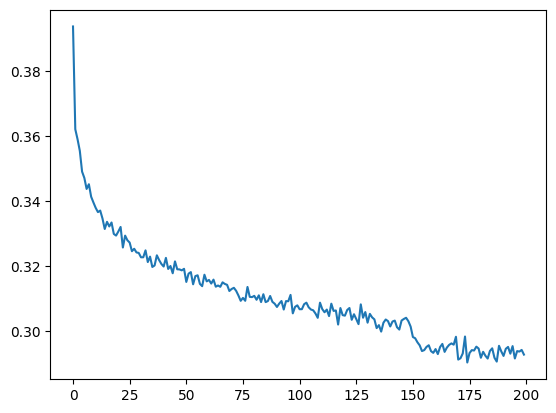

In [13]:
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [14]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [15]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9417067766189575
val 2.267648220062256


In [16]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

rohan.
jaf.
kais.
abbalyd.
jowe.
briagros.
leamir.
bettani.
fordino.
lyanna.
bamyro.
yaviya.
chaistob.
sajay.
sephan.
borah.
aovane.
amirs.
jocel.
elynn.


In [17]:
import torch

def save_parameters(model, path="namegram_params.pt"):
    params = model.parameters()
    state = {f'param_{i}': p for i, p in enumerate(params)}
    torch.save(state, path)
    print(f"✅ Parameters saved to {path}")

def load_parameters(model, path="namegram_params.pt"):
    state = torch.load(path)
    params = model.parameters()
    for p, (_, loaded) in zip(params, state.items()):
        with torch.no_grad():
            p.copy_(loaded)
    print(f"✅ Parameters loaded from {path}")


In [23]:

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model1 = Sequential([
  EmbeddingLayer(vocab_size, n_embd),
  FlattenConsecutive(2), LinearLayer(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), LinearLayer(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), LinearLayer(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  LinearLayer(n_hidden, vocab_size),
])
# 2. Save model parameters



In [24]:

# 2. Save model parameters
save_parameters(model, "namegram_params.pt")

load_parameters(model1, "namegram_params.pt")


✅ Parameters saved to namegram_params.pt
✅ Parameters loaded from namegram_params.pt


In [28]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model1(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

C:\Users\kanda\AppData\Local\Temp\ipykernel_5464\2917052304.py:82: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  xvar = x.var(dim, keepdim=True) # batch variance


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0